# Boia Itajaí

- Data: https://www.marinha.mil.br/chm/sites/www.marinha.mil.br.chm/files/historico_itajai_0.txt
- Metadata: https://www.marinha.mil.br/chm/sites/www.marinha.mil.br.chm/files/u1947/metadados.txt

<span style="color: red;">FIXME: Metadata says the column is `spred` but it looks like it is `spread` instead.</span>

```
Estes dados foram qualificados utilizando os procedimentos descritos no
arquivo "CONTROLE_DE_QUALIDADE_DOS_DADOS.pdf". Esta qualificacao ainda esta em 
fase de testes. E possivel que possam ser verificados alguns erros e
incongruencias. Por favor, entrem em contato com "chm.pnboia@marinha.mil.br"
caso voce perceba alguma coisa errada. O seu feedback é essencial para melhorar
a qualidade dos nossos dados.

Os adcps sao configurados da seguinte forma:

A) BOIAS PROFUNDAS
Profundidade do ADCP: 0.5 metros
Blank distance: 5.0 metros
Tamanho da celula: 3.5 metros
Profundidade da primeira celula: 5.5 metros
Profundidade da ultima celula: 75.5 metros

As colunas dos dados apresentam a seguinte representacao:

- Datetime: DATA/HORA NO FUSO GMT (Formato: YYYY-MM-DD HH:mm:ss) 
- lon: Longitude
- lat: Latitude	
- Battery: Tensao da bateria da boia (V)
- bhead: Alinhamento da Boia (graus)
- wspd: Velocidade do Vento corrigido a 10 metros (m/s)
- wdir: Direcao do Vento corrigido a 10 metros, corrigido para o norte verdadeiro
- gust: Rajada do Vento corrigido a 10 metros (m/s)
- atmp: Temperatura do Ar (graus C)
- pres: Pressao Atmosferica (mb)
- dewp: Ponto de Orvalho (graus C)
- humi: Umidade Relativa (%)
- wtmp: Temperatura da Superficie do Mar (graus C)
- cvel01: Velocidade da Corrente na celula 01, mais próxima do ADCP (mm/s)
- cdir01: Dir da Corr na celula 01, mais próxima do ADCP (graus), corrigido para norte verdadeiro
- cvel02: Vel da Corr na celula 02, segunda mais próxima do ADCP (mm/s)
- cdir02: Dir da Corr na celula 02, segunda mais próxima do ADCP (graus), corrigido para norte verdadeiro
- cvel03: Vel da Corr na celula 03, terceira mais próxima do ADCP (mm/s)
- cdir03: Dir da Corr na celula 03, terceira mais próxima do ADCP (graus), corrigido para norte verdadeiro
- wvht: Altura Significativa de Ondas (m)
- wmax: Altura Maxima de Ondas (m)
- dpd: Periodo de Pico (s)
- mwd: Direcao de Ondas media (graus), corrigido para o norte verdadeiro
- spred: Espalhamento (graus)
```

In [1]:
import pandas as pd


fname = "historico_itajai_0.txt"
df = pd.read_csv(fname, index_col="# Datetime", parse_dates=True, na_values="-9999.0")

df.columns = df.columns.str.lower()
df.index.name = "datetime"

In [2]:
rows, cols = df.shape

print(
    f"We have {rows} rows and {cols} columns.\n\n"
    f"The columns are: {', '.join(df.columns)}.\n\n"
    f"The time-series spans from {df.index[0]:%d-%b-%Y} to {df.index[-1]:%d-%b-%Y}."
)

We have 53622 rows and 23 columns.

The columns are: lat, lon, battery, bhead, wspd, wdir, gust, atmp, pres, dewp, humi, wtmp, cvel1, cdir1, cvel2, cdir2, cvel3, cdir3, wvht, wmax, dpd, mwd, spread.

The time-series spans from 23-Apr-2009 to 19-Oct-2019.


Clean up rows that are all NaNs and places where we do not have location data.

In [3]:
df = df.dropna(how="all", axis=0)

print(f"Dropped {rows-df.shape[0]} rows with all NaNs.")

# Also drop those where we don't have the location.
df = df.loc[~df["lon"].isnull()]
df = df.loc[~df["lat"].isnull()]

print(f"Dropped {rows-df.shape[0]} rows without lon or lat data.")

Dropped 93 rows with all NaNs.
Dropped 3039 rows without lon or lat data.


In [4]:
import geopandas
from cartopy.io.shapereader import natural_earth


fname = natural_earth(
    resolution="10m",
    category="physical",
    name="coastline"
)

gdf = geopandas.read_file(fname)

### Check positions

In [5]:
dx = dy = 0.5

lon_min, lon_max = df["lon"].min()-dx, df["lon"].max()+dx
lat_min, lat_max = df["lat"].min()-dy, df["lat"].max()+dy

In [6]:
from shapely.geometry import Polygon, mapping
from shapely.ops import unary_union


aoi = gdf.cx[lon_min:lon_max, lat_min:lat_max]
geoms = unary_union(aoi["geometry"])
            
(coastline, island) = [
    Polygon(mapping(x)["coordinates"]) for x in
    geoms.geoms
]

In [7]:
import numpy as np
from shapely.geometry import Point


def in_polygon_shapely(polygon, xp, yp):
    return np.array(
        [
            Point(x, y).intersects(polygon) for x, y in
            zip(xp, yp)], dtype=bool,
    )


mask_coast = in_polygon_shapely(coastline, df["lon"], df["lat"])
mask_island = in_polygon_shapely(island, df["lon"], df["lat"])

mask = mask_coast + mask_island

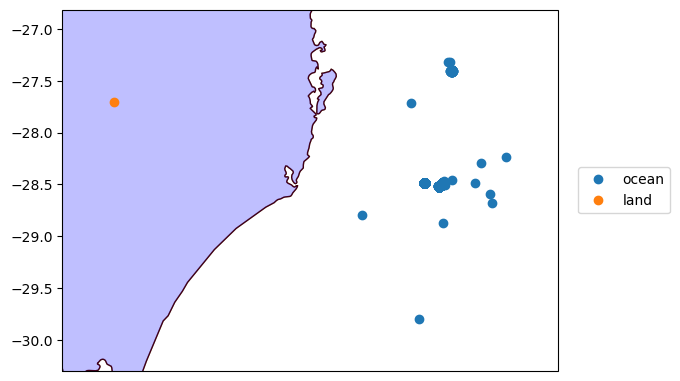

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


projection = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw={"projection": projection})

groups = df.groupby(pd.Grouper(freq="Y"))

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
c = ax.coastlines()

ocean = df[~mask]
ocean.plot(x="lon", y="lat", ax=ax, marker="o", linestyle="none", label="ocean")

land = df[mask]
land.plot(x="lon", y="lat", ax=ax, marker="o", linestyle="none", label="land")

ax.add_geometries([coastline, island], crs=projection, facecolor="b", edgecolor="red", alpha=0.25)
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);

## <span style="color: red;">There are points inland, removing them for now. Remember to report later!</span>

In [9]:
df[mask][["lon", "lat"]]

,lon,lat
datetime,,
2011-06-20 12:00:00,-50.5165,-27.7051


### Select the ocean ones

In [10]:
df = df[~mask]

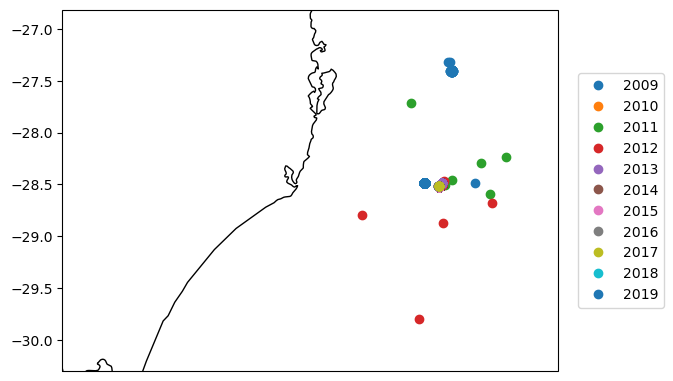

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": projection})

groups = df.groupby(pd.Grouper(freq="Y"))

for (k, group) in groups:
    group.plot(
        x="lon",
        y="lat",
        ax=ax,
        marker="o",
        linestyle="none",
        label=k.year
    )

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
c = ax.coastlines()
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);

### The buoy deployments are all over the place and quite far apart. Let's investigate this location spread and find deployments that can be used together.

The data below is from https://www.marinha.mil.br/chm/sites/www.marinha.mil.br.chm/files/u1947/historico.pdf

In [12]:
import io

table = """
deployment,recovery,lat,lon
23/04/2009,10/12/2009,28°29.20'S,047°31.50'W
17/02/2011,03/10/2012,28°29.867'S,047°21.63'W
01/02/2013,26/09/2013,28°29.077'S,047°21.599'W
06/11/2014,29/10/2015,28°31.14'S,047°23.42'W
10/04/2016,03/02/2017,28°30.926'S,047°23.470'W
04/02/2017,03/09/2019,27°24.36'S,047°15.93'W
"""

table = pd.read_csv(io.StringIO(table), parse_dates=["deployment", "recovery"], dayfirst=True)

In [13]:
def fix_pos(pos):
    deg, rest = pos.split("°")
    m, d = rest.split("'")

    if d in ["S", "W"]:
        sign = -1
    elif d in ["N", "E"]:
        sign = 1
    else:
        raise ValueError(f"Unregonized sign {d}.")

    return sign*(float(deg) + float(m)/60.)

In [14]:
table["lat"] = table["lat"].apply(fix_pos)
table["lon"] = table["lon"].apply(fix_pos)

In [15]:
deployments = {}
for (k, row) in table.iterrows():
    begin, end = row[["deployment", "recovery"]]
    sliced = df.loc[begin:end]
    deployments.update({k: sliced})

records = [deployments[key].shape[0] for key in deployments.keys()]
table["records"] = records

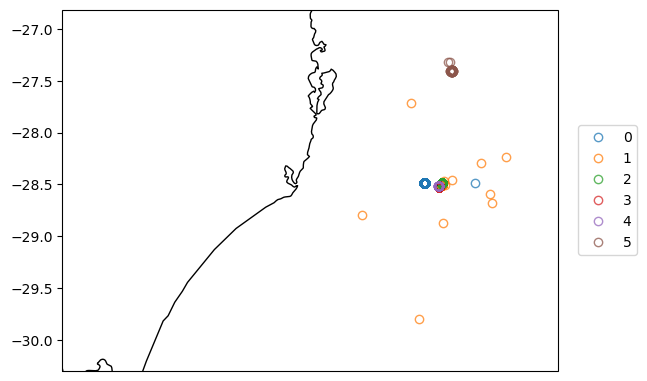

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": projection})

for (k, sliced) in deployments.items():
    sliced.plot(
        x="lon",
        y="lat",
        ax=ax,
        marker="o",
        markerfacecolor="none",
        linestyle="none",
        alpha=0.75,
        label=k
    )

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
c = ax.coastlines()
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);

In [17]:
table

,deployment,recovery,lat,lon,records
0,2009-04-23,2009-12-10,-28.486667,-47.525000,5131
1,2011-02-17,2012-10-03,-28.497783,-47.360500,14023
2,2013-02-01,2013-09-26,-28.484617,-47.359983,4105
3,2014-11-06,2015-10-29,-28.519000,-47.390333,8541
4,2016-04-10,2017-02-03,-28.515433,-47.391167,2758
5,2017-02-04,2019-09-03,-27.406000,-47.265500,15980


We have 6 ployments. We will drop deployment 1 b/c the GPS data is either unreliable or the buoy got lose and drifted.

In [18]:
dep0 = deployments.pop(1)

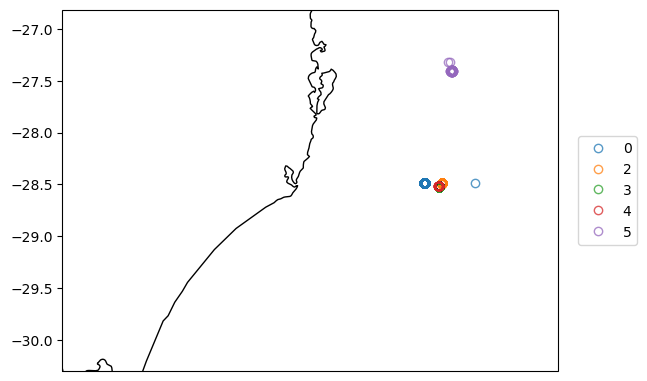

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": projection})

for (k, sliced) in deployments.items():
    sliced.plot(
        x="lon",
        y="lat",
        ax=ax,
        marker="o",
        markerfacecolor="none",
        linestyle="none",
        alpha=0.75,
        label=k
    )

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
c = ax.coastlines()
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);

Now we can identify at 3, maybe two?, groups of deployments. Deployment 0 has a data point quite far from the main cluster. We should identify that and remove it.

Looks like we can safely group deployments 2, 3, 4. Deployment 5 is quite far and should be in another group. Deployment 0 could be grouped with 2, 3, 4 but we need to check the distance and remove the outlier.

### Wave data from deployments 2, 3, 4


This is just a quick data check. We will use depoyment 5 later b/c it has more records and its position seems to be consistent.

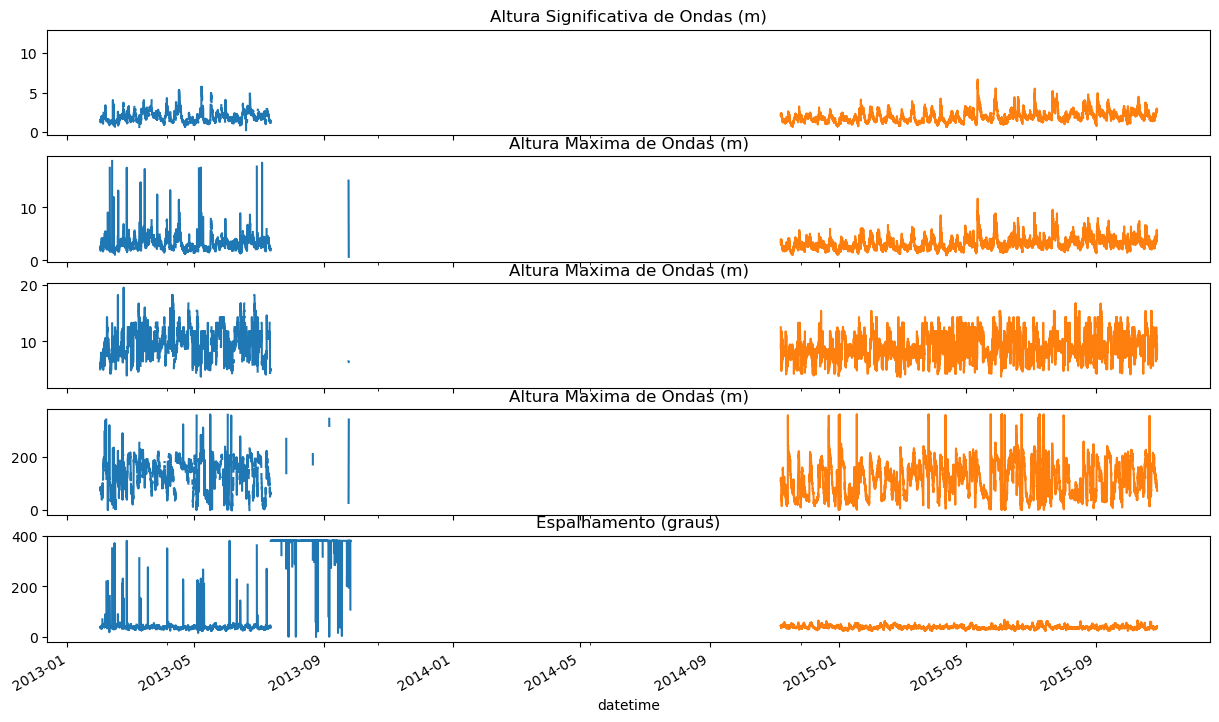

In [20]:
fig, axes = plt.subplots(
    figsize=(15, 9), nrows=5, ncols=1,
    sharex=True,
)

for deployment in [2, 3, 4]:
    waves = deployments[deployment]
    
    waves["wvht"].plot(ax=axes[0])
    axes[0].set_title("Altura Significativa de Ondas (m)")

    waves["wmax"].plot(ax=axes[1])
    axes[1].set_title("Altura Maxima de Ondas (m)")
    
    waves["dpd"].plot(ax=axes[2], label="Periodo de Pico (s)")
    axes[2].set_title("Altura Maxima de Ondas (m)")
    
    waves["mwd"].plot(ax=axes[3], label="Direcao de Ondas media (graus)")
    axes[3].set_title("Altura Maxima de Ondas (m)")
    
    waves["spread"].plot(ax=axes[4])
    axes[4].set_title("Espalhamento (graus)");

### Deployment 5

In [21]:
df = deployments[5]

deployment, recovery, lat, lon, records = table.loc[5]

print(
    f"Deployment 5 was installed at {lon=}, {lat=}\n"
    f"From {deployment:%d-%b-%Y} to {recovery:%d-%b-%Y}\n"
    f"With {records} records."
)

Deployment 5 was installed at lon=-47.2655, lat=-27.406
From 04-Feb-2017 to 03-Sep-2019
With 15980 records.


Let's filter what we consider bad positions, they may containg good data but we do not have the QA/QC flags to be sure and it is metter to remove them for now.

In [22]:
import numpy as np


rtol = 0.0004  # Relative tolerance
mask = np.isclose(df["lon"], lon, rtol=rtol)


pos = df[["lon", "lat"]][mask]
removed = df[["lon", "lat"]][~mask]


deg2m = 111000
print(
    f"Removing points ~{rtol * deg2m} meters from the center.\n\n"
    f"The points removed are:\n{removed}."
)

Removing points ~44.4 meters from the center.

The points removed are:
                        lon     lat
datetime                           
2019-06-02 08:00:00 -47.285 -27.316
2019-06-02 10:00:00 -47.301 -27.323.


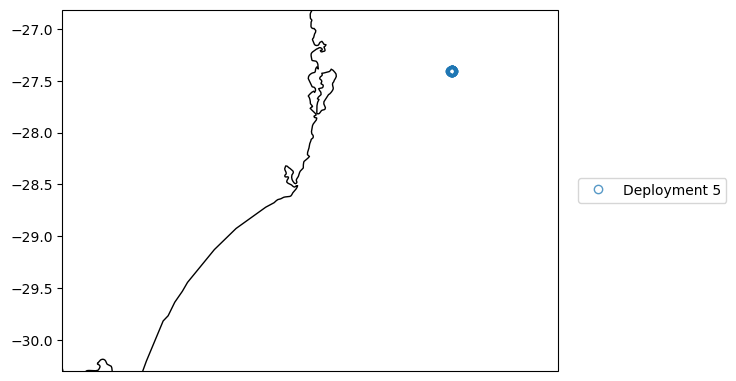

In [23]:
fig, ax = plt.subplots(subplot_kw={"projection": projection})

pos.plot(
    x="lon",
    y="lat",
    ax=ax,
    marker="o",
    markerfacecolor="none",
    linestyle="none",
    alpha=0.75,
    label="Deployment 5",
)

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
c = ax.coastlines()
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);

## Meteo/Waves

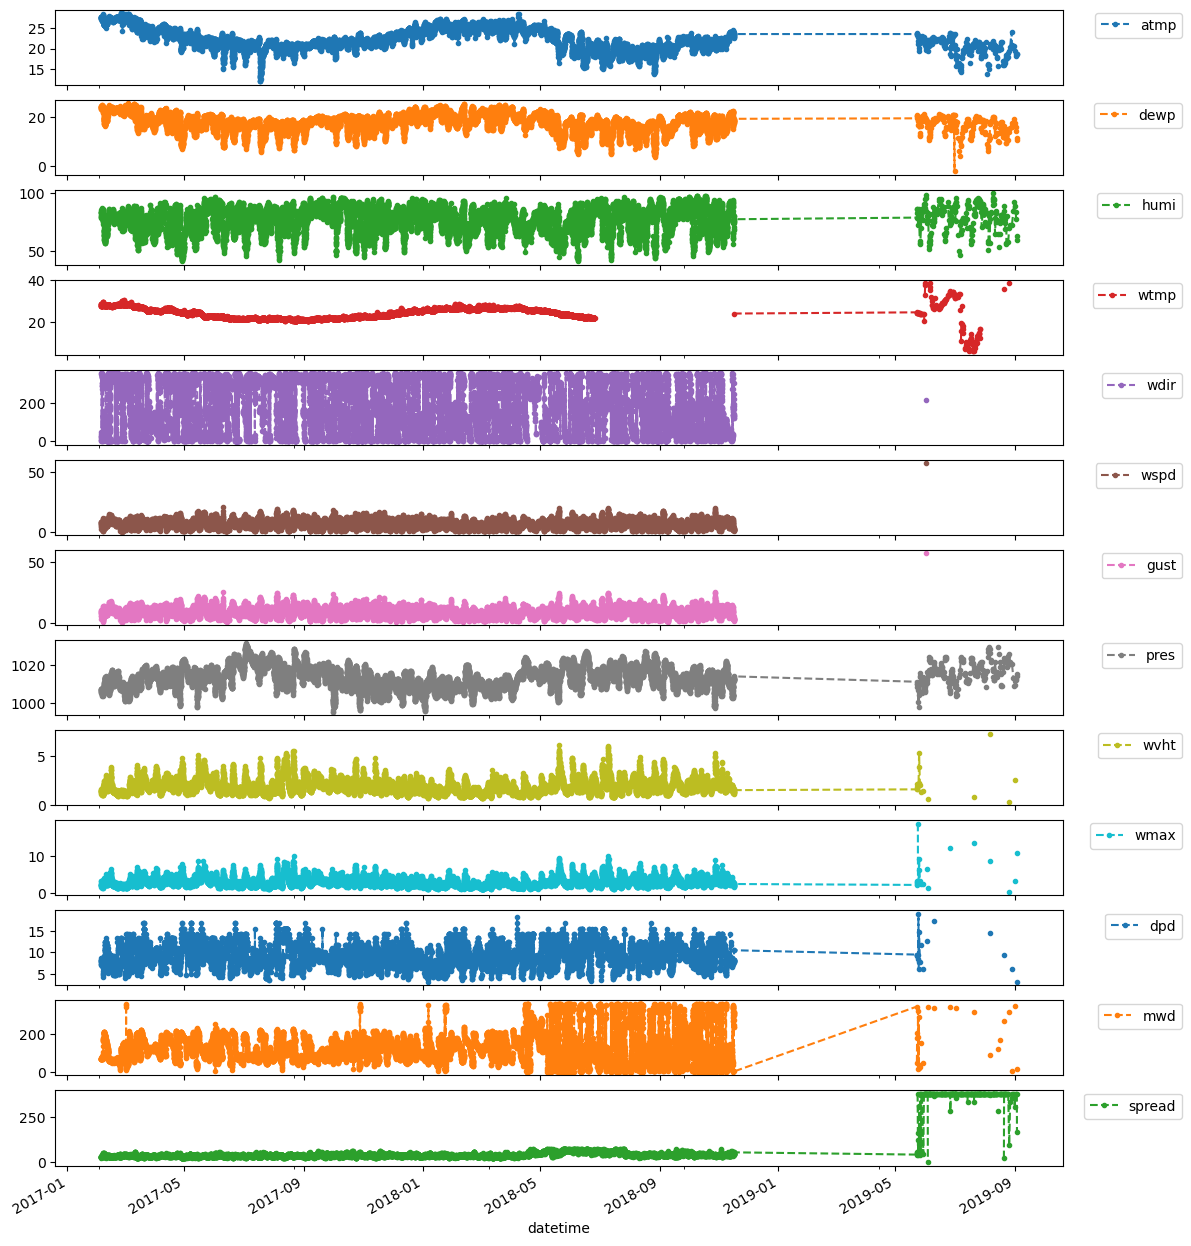

In [24]:
wave_cols = ["wvht", "wmax", "dpd", "mwd", "spread"]
meteo_cols = ["atmp", "dewp", "humi", "wtmp", "wdir", "wspd", "gust", "pres"]

df = df[meteo_cols+wave_cols]

axes = df.plot(
    subplots=True,
    layout=(13, 1),
    figsize=(13, 17),
    
    marker=".",
    linestyle="--",
)

[ax.legend(bbox_to_anchor=(1.125, 1.05)) for ax in axes.ravel()];

Around January of 2019 we have a hiatus, maybe maintenance, and then some sparse data. The `wdir`, `wspd`, `gust` have one 1 data point and the other display a variance much higher then before. For the sake of simplicity we will drop any data after Jan-2019 from now one.

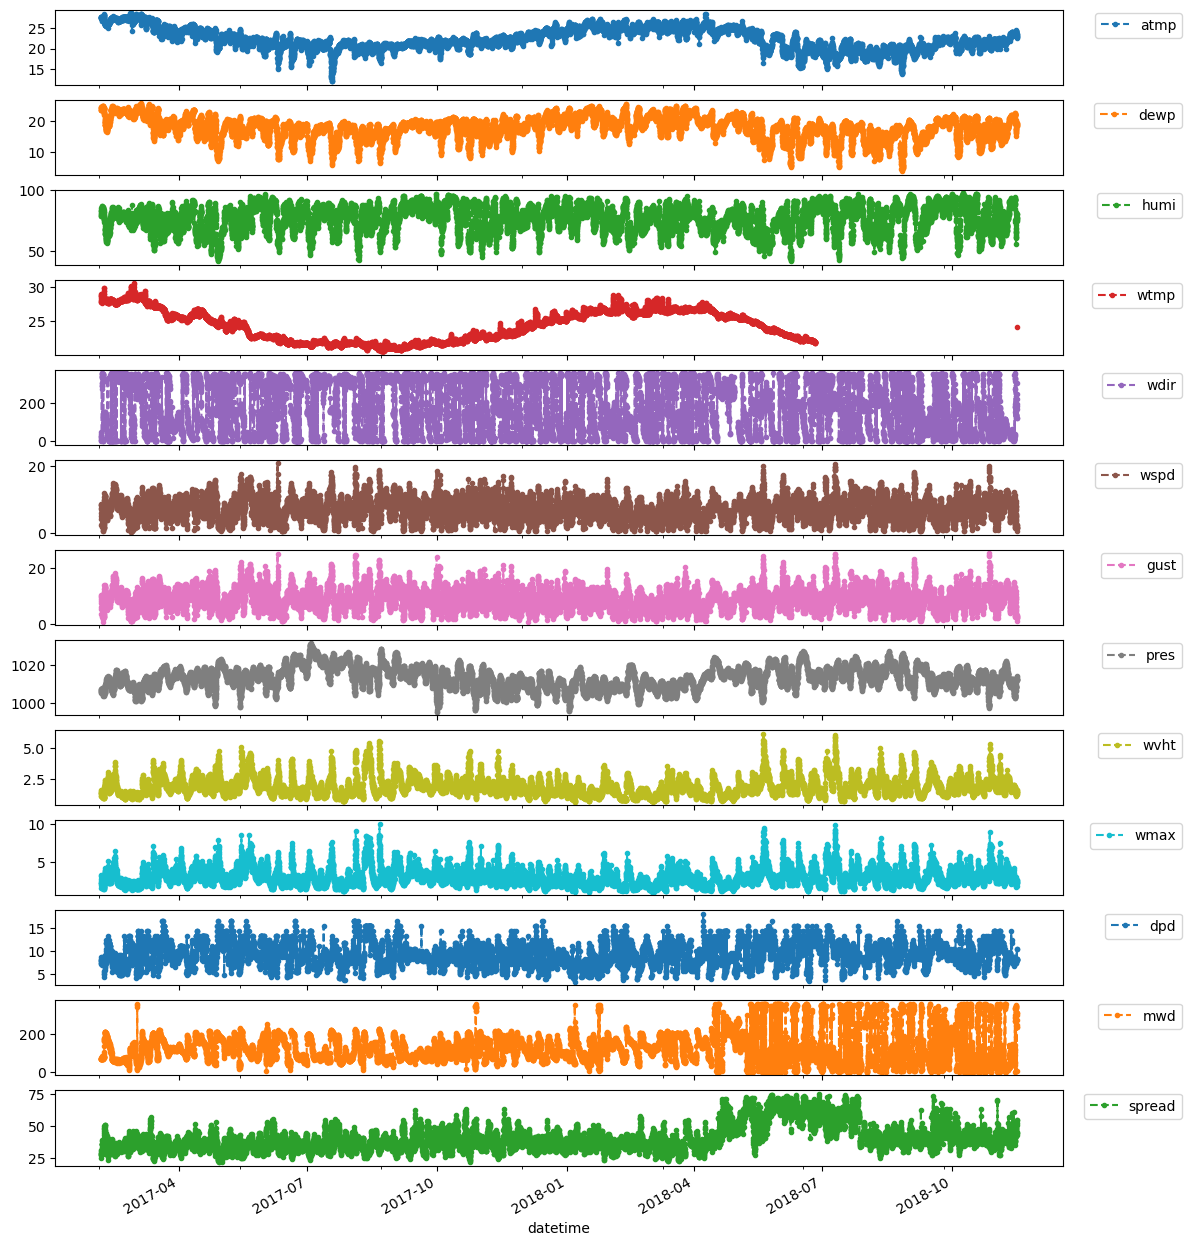

In [25]:
df = df[:"2019-01"]

axes = df.plot(
    subplots=True,
    layout=(13, 1),
    figsize=(13, 17),
    marker=".",
    linestyle="--",
)

[ax.legend(bbox_to_anchor=(1.125, 1.05)) for ax in axes.ravel()];

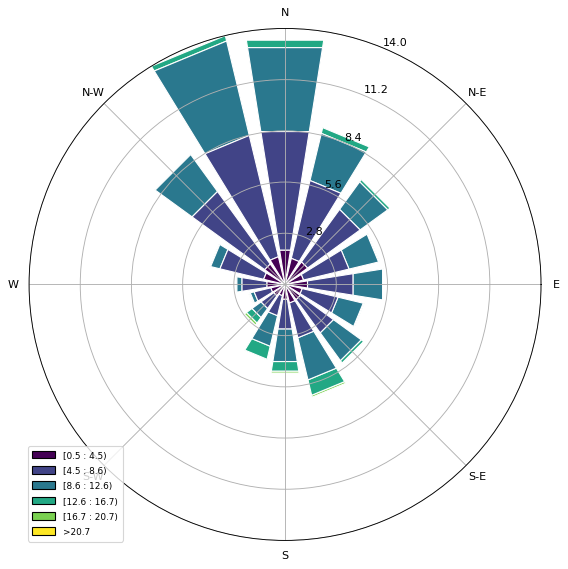

In [26]:
from windrose import WindroseAxes


ax = WindroseAxes.from_ax()
ax.bar(df["wdir"], df["wspd"], normed=True, opening=0.8, edgecolor="white")
ax.set_legend();

## Waves

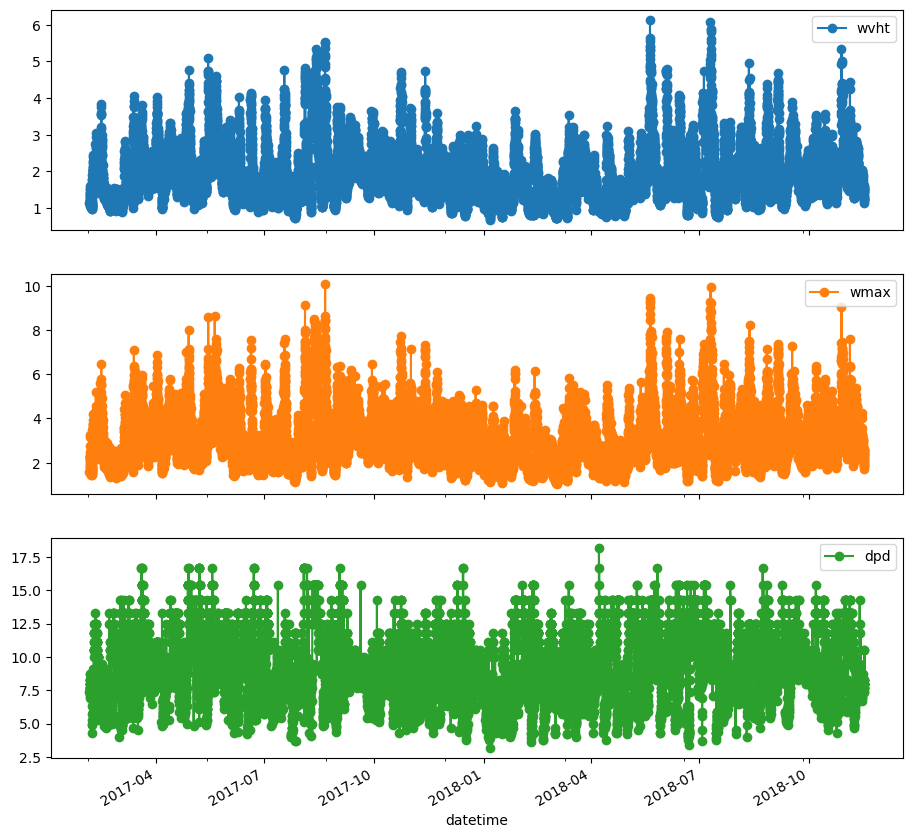

In [27]:
axes = df[["wvht", "wmax", "dpd"]].plot(marker="o",
    subplots=True,
    layout=(3, 1),
    figsize=(11, 11)
)

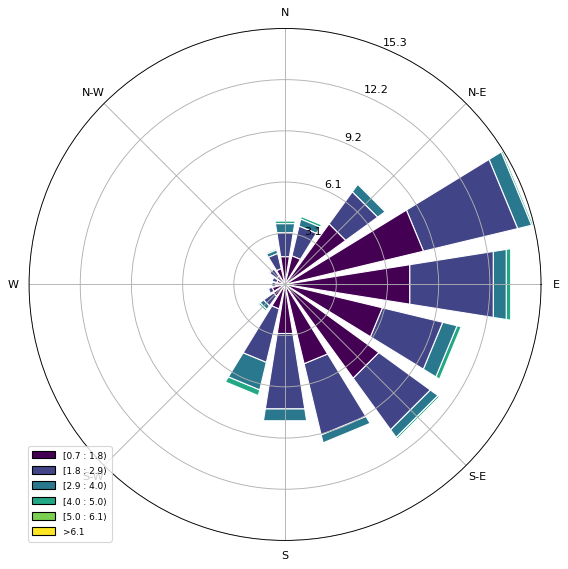

In [28]:
from windrose import WindroseAxes


ax = WindroseAxes.from_ax()
ax.bar(df["mwd"], df["wvht"], normed=True, opening=0.8, edgecolor="white")
ax.set_legend();

### The variable `wvht` is Wave Significant Height, the variable of interest for the oil model.

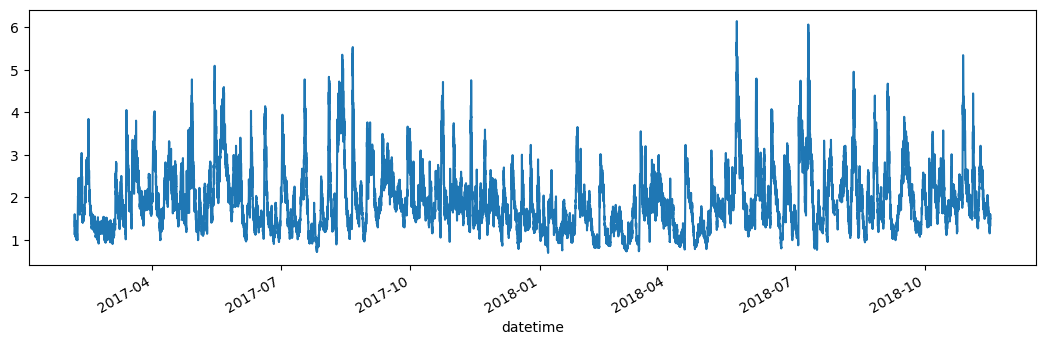

In [29]:
ax = df["wvht"].plot(figsize=(13, 3.75))

# Selection

<IPython.core.display.Javascript object>


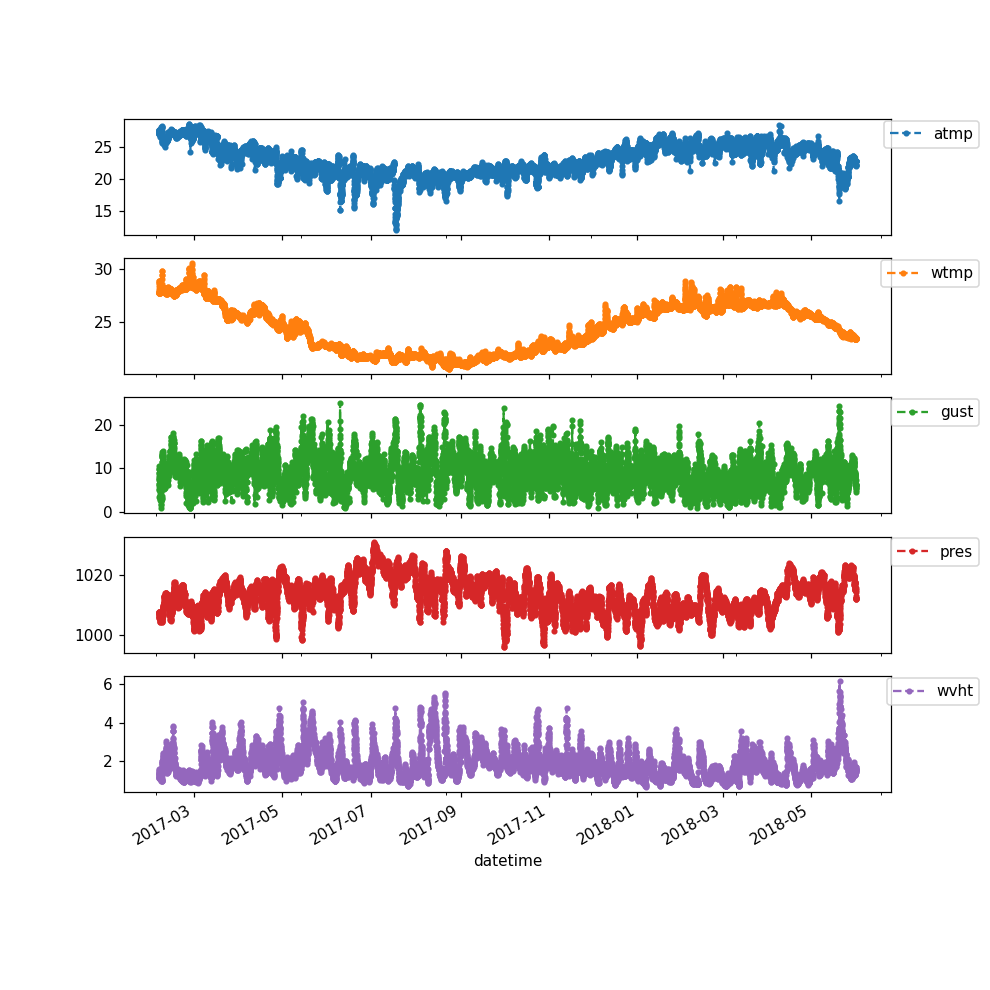

In [30]:
%matplotlib notebook
df = df[:"2018-05"]

axes = df[["atmp", "wtmp", "gust", "pres", "wvht"]].plot(
    subplots=True,
    layout=(5, 1),
    figsize=(9, 9),
    marker=".",
    linestyle="--",
)

[ax.legend(bbox_to_anchor=(1.125, 1.05)) for ax in axes.ravel()];

In [34]:
df.index[0], df.index[-1]

(Timestamp('2017-02-04 15:00:00'), Timestamp('2018-05-31 23:00:00'))